# 1. Import Packages and Define Functions

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
seed=42
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [5]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https", "rt"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [6]:
stopwords = list(set(stopwords))

In [7]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [8]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [9]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [10]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [11]:
def get_subjectivity(tweet):
    b = TextBlob(tweet)
    return b.sentiment.subjectivity

In [12]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [13]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [14]:
def ReplaceThreeOrMore(tweet):
    # pattern to look for three or more repetitions of any character, including
    # newlines.
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", tweet)

In [15]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tweet = ReplaceThreeOrMore(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [16]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [17]:
df = pd.read_csv("tweets_4_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,exclamation_points,top_emoji
0,i dont want to vote for pedophile biden im sor...,-0.7447,0.000000,😩
1,I ll kidnap 1000 children before I let this co...,-0.2942,0.010101,😊
2,omg there s more on the ballot then just the p...,-0.7003,0.000000,😱
3,AméricaniseUnTitre The Trump Tower Infernale,0.4588,0.000000,😊
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.5437,0.021429,😊


In [18]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

i dont want to vote for pedophile biden im sorry what
dont want vote pedophile biden im sorry
<class 'str'>


In [19]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

In [20]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    2617.000000
mean        0.596261
std         0.307721
min         0.000000
25%         0.304228
50%         0.690462
75%         0.874311
max         1.000000
Name: sentiment_score, dtype: float64

In [21]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 2617/2617 [00:00<00:00, 7810.59it/s]


,tweet,sentiment_score,exclamation_points,top_emoji,capitalization
0,i dont want to vote for pedophile biden im sor...,0.126140,0.000000,😩,0.000000
1,I ll kidnap 1000 children before I let this co...,0.351818,0.010101,😊,0.111111
2,omg there s more on the ballot then just the p...,0.148382,0.000000,😱,0.000000
3,AméricaniseUnTitre The Trump Tower Infernale,0.729035,0.000000,😊,0.000000
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.771566,0.021429,😊,0.037037


In [22]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 2617/2617 [00:07<00:00, 331.51it/s]


,tweet,sentiment_score,exclamation_points,top_emoji,capitalization,profanity
0,i dont want to vote for pedophile biden im sor...,0.126140,0.000000,😩,0.000000,0.000000
1,I ll kidnap 1000 children before I let this co...,0.351818,0.010101,😊,0.111111,0.010753
2,omg there s more on the ballot then just the p...,0.148382,0.000000,😱,0.000000,0.000000
3,AméricaniseUnTitre The Trump Tower Infernale,0.729035,0.000000,😊,0.000000,0.000000
4,Biden will WIN Trump and DeJoy have cheated!! ...,0.771566,0.021429,😊,0.037037,0.007576


In [23]:
df['subjectivity'] = df.tweet.progress_apply(get_subjectivity)

100%|██████████| 2617/2617 [00:00<00:00, 2755.75it/s]


In [24]:
# test the replacing of extra chars
test = "yoooooo let's gooooo to the zoooo. Wazzzzuppppp. AAABBBCCC"

In [25]:
ReplaceThreeOrMore(test)

"yoo let's goo to the zoo. Wazzupp. AABBCC"

In [26]:
df.top_emoji.value_counts()

😊    1487
😩     625
😡     335
😱     170
Name: top_emoji, dtype: int64

# 3. Dummy Classifier for Baseline Model

In [27]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity', 'exclamation_points']]

In [28]:
y =df['top_emoji']

In [29]:
from sklearn.dummy import DummyClassifier

In [30]:
dummy_cf = DummyClassifier(strategy='uniform')
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.25066870462361485


In [31]:
accuracy = accuracy_score(y, y_preds)


In [32]:
results=[]
results.append(('Dummy', accuracy))

In [33]:
results

[('Dummy', 0.2457011845624761)]

In [34]:
df.top_emoji.value_counts()

😊    1487
😩     625
😡     335
😱     170
Name: top_emoji, dtype: int64

### RESAMPLE

In [35]:
from sklearn.utils import resample
cry = df[df.top_emoji == '😩']
happy = df[df.top_emoji == '😊']
fear = df[df.top_emoji == '😱']
anger = df[df.top_emoji == '😡']


cry_downsampled = resample(cry,
                          replace=False,
                          n_samples=int(len(fear)*1.5), # match number
                          random_state=seed) 

happy_downsampled = resample(happy,
                          replace=False,
                          n_samples=int(len(fear)*1.5), # match number 
                          random_state=seed) 
fear_upsampled = resample(fear,
                          replace=True, 
                          n_samples=int(len(fear)*1.5), # match number 
                          random_state=seed) 
anger_downsampled = resample(anger,
                          replace=False,
                          n_samples=int(len(fear)*1.5), # match number 
                          random_state=seed) 

df = pd.concat([cry_downsampled, happy_downsampled, fear_upsampled, anger_downsampled])
df.top_emoji.value_counts()

😡    255
😊    255
😩    255
😱    255
Name: top_emoji, dtype: int64

In [36]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity', 'exclamation_points']]

In [37]:
y =df['top_emoji']

# 4. Supervised Learning

In [38]:
import en_core_web_sm
nlp = en_core_web_sm.load()
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'cap':  row['capitalization'], 'prof': row['profanity'],
                 'sent': row['sentiment_score'], 'excla': row['exclamation_points']} for _, row in data.iterrows()]
    

In [40]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),
            
#             ('embedding', Pipeline([
#                 ('selector', ItemSelector(key='tweet')),
#                 ("mean_embeddings", SpacyVectorTransformer(nlp))
#             ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['capitalization','profanity','sentiment_score','exclamation_points'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 1,#0.9,
#             'embedding': 1,
            'stats': 1 #1.5,
        },
    ))
], verbose=True)

In [41]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [42]:
pipeline.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   0.3s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  preprocessor=<function clean_txt at 0x11b769a60>,
                                                                                  smooth_idf=1,
                                                           

In [43]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the shapes match: (816, 796) - (204, 796)
CPU times: user 366 ms, sys: 3.49 ms, total: 369 ms
Wall time: 369 ms


### LogReg

Algorithm to use in the optimization problem.

    - For small datasets, 'liblinear' is a good choice, whereas 'sag' and
      'saga' are faster for large ones.
    - For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs'
      handle multinomial loss; 'liblinear' is limited to one-versus-rest
      schemes.
    - 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas
      'liblinear' and 'saga' handle L1 penalty.
    - 'liblinear' might be slower in LogisticRegressionCV because it does
      not handle warm-starting.


In [44]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [45]:
lr_clf = LogisticRegressionCV(solver='newton-cg', cv=10, penalty='l2', Cs = [.001,.01,.1,1,10,100], 
                                    max_iter=10000, verbose=True, n_jobs=-1, scoring='f1', multi_class='ovr',
                                class_weight='balanced')
lr_clf.fit(train_vec, y_train)
test_preds = lr_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.4s finished


In [46]:
accuracy = accuracy_score(y_test, test_preds)
print('LogReg')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('LogReg', accuracy))

LogReg
Testing Accuracy: 0.6569


In [47]:
print(classification_report(y_test, test_preds))
print('----------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.75      0.80      0.77        51
           😡       0.53      0.61      0.56        51
           😩       0.59      0.43      0.50        51
           😱       0.75      0.78      0.77        51

    accuracy                           0.66       204
   macro avg       0.66      0.66      0.65       204
weighted avg       0.66      0.66      0.65       204

----------------------------------------
[[41  6  4  0]
 [ 7 31  7  6]
 [ 6 16 22  7]
 [ 1  6  4 40]]


### SVM(s)

#### LinearSVC

In [48]:
from sklearn.svm import LinearSVC

In [49]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=seed,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [50]:
accuracy = accuracy_score(y_test, test_preds)
print('Linear SVC')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('Linear SVC', accuracy))

Linear SVC
Testing Accuracy: 0.6569


#### GridSVC

In [51]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [52]:
param_grid = {'C':[.1,1,10],'gamma':[10,1,0.1]}

In [53]:
grid_svc=GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svc.fit(train_vec, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [10, 1, 0.1]},
             scoring='accuracy', verbose=1)

In [54]:
print(grid_svc.best_score_)
print(grid_svc.best_params_)
print(grid_svc.best_estimator_)

0.6422312556458898
{'C': 10, 'gamma': 1}
SVC(C=10, gamma=1)


In [55]:
test_preds = grid_svc.best_estimator_.predict(test_vec)

In [56]:
accuracy = accuracy_score(y_test, test_preds)
print('SVC Grid')
print("Testing Accuracy: {:.4}".format(accuracy))

SVC Grid
Testing Accuracy: 0.701


In [57]:
results.append(('SVC_Grid', accuracy))
results

[('Dummy', 0.2457011845624761),
 ('LogReg', 0.6568627450980392),
 ('Linear SVC', 0.6568627450980392),
 ('SVC_Grid', 0.7009803921568627)]

### Random Forest

In [58]:
rfc_clf = RandomForestClassifier(n_estimators=250, random_state=seed,n_jobs=-1,verbose=1, class_weight='balanced')
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


In [59]:
accuracy = accuracy_score(y_test, test_preds)
print('Random Forest')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('RFC', accuracy))

Random Forest
Testing Accuracy: 0.7059


In [60]:
print(classification_report(y_test, test_preds))
print('----------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.84      0.92      0.88        51
           😡       0.60      0.59      0.59        51
           😩       0.58      0.49      0.53        51
           😱       0.76      0.82      0.79        51

    accuracy                           0.71       204
   macro avg       0.70      0.71      0.70       204
weighted avg       0.70      0.71      0.70       204

----------------------------------------
[[47  3  1  0]
 [ 2 30 12  7]
 [ 6 14 25  6]
 [ 1  3  5 42]]


### MN Bayes

In [61]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
mnb_clf.fit(train_vec, y_train)
test_preds = mnb_clf.predict(test_vec)

In [62]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('MNBayes', accuracy))

MN Bayes
Testing Accuracy: 0.549


### Bernoulli Bayes

In [63]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
bb_clf.fit(train_vec, y_train)
test_preds = bb_clf.predict(test_vec)

In [64]:
accuracy = accuracy_score(y_test, test_preds)
print('Bernoulli Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('BerBayes', accuracy))

Bernoulli Bayes
Testing Accuracy: 0.451


In [65]:
results

[('Dummy', 0.2457011845624761),
 ('LogReg', 0.6568627450980392),
 ('Linear SVC', 0.6568627450980392),
 ('SVC_Grid', 0.7009803921568627),
 ('RFC', 0.7058823529411765),
 ('MNBayes', 0.5490196078431373),
 ('BerBayes', 0.45098039215686275)]

### Passive Aggressive Classifier

In [66]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [67]:
#PassiveAggresive Classifier
pac_clf = PassiveAggressiveClassifier() 
pac_clf.fit(train_vec, y_train)
test_preds = pac_clf.predict(test_vec)

In [68]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('PassiveAgg', accuracy))

MN Bayes
Testing Accuracy: 0.6176


In [69]:
results

[('Dummy', 0.2457011845624761),
 ('LogReg', 0.6568627450980392),
 ('Linear SVC', 0.6568627450980392),
 ('SVC_Grid', 0.7009803921568627),
 ('RFC', 0.7058823529411765),
 ('MNBayes', 0.5490196078431373),
 ('BerBayes', 0.45098039215686275),
 ('PassiveAgg', 0.6176470588235294)]

### XGBoost

In [70]:
import xgboost as xgb

In [71]:
# RUN A BASELINE XGB
xg = xgb.XGBClassifier()
xg.fit(train_vec, y_train,eval_metric='merror')
test_preds = xg.predict(test_vec)

In [72]:
accuracy = accuracy_score(y_test, test_preds)
print('XGBoost')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('XGB', accuracy))

XGBoost
Testing Accuracy: 0.6765


In [73]:
results

[('Dummy', 0.2457011845624761),
 ('LogReg', 0.6568627450980392),
 ('Linear SVC', 0.6568627450980392),
 ('SVC_Grid', 0.7009803921568627),
 ('RFC', 0.7058823529411765),
 ('MNBayes', 0.5490196078431373),
 ('BerBayes', 0.45098039215686275),
 ('PassiveAgg', 0.6176470588235294),
 ('XGB', 0.6764705882352942)]

In [74]:
from sklearn.metrics import f1_score

In [75]:
print(classification_report(y_test, test_preds))
print('---------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.89      0.80      0.85        51
           😡       0.55      0.67      0.60        51
           😩       0.56      0.47      0.51        51
           😱       0.74      0.76      0.75        51

    accuracy                           0.68       204
   macro avg       0.68      0.68      0.68       204
weighted avg       0.68      0.68      0.68       204

---------------------------------------
[[41  8  2  0]
 [ 2 34 10  5]
 [ 2 16 24  9]
 [ 1  4  7 39]]


### Voting Classifier

In [76]:
from sklearn.ensemble import VotingClassifier

In [77]:
voting_clf = VotingClassifier(
                estimators=[('logreg', lr_clf), ('svm_linear', sv_clf), ('pass_aggr', pac_clf),
                            ('smv_grid', grid_svc.best_estimator_), ('xgboost', xg), ('rfc', rfc_clf),
                            ('mnbayes', mnb_clf),('berbayes', bb_clf)], #
                voting='hard', verbose=1, n_jobs= -1)
voting_clf.fit(train_vec, y_train)
test_preds = voting_clf.predict(test_vec)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


In [78]:
accuracy = accuracy_score(y_test, test_preds)
print('Voting')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('Voting', accuracy))

Voting
Testing Accuracy: 0.6863


In [79]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('RFC', 0.7058823529411765),
 ('SVC_Grid', 0.7009803921568627),
 ('Voting', 0.6862745098039216),
 ('XGB', 0.6764705882352942),
 ('LogReg', 0.6568627450980392),
 ('Linear SVC', 0.6568627450980392),
 ('PassiveAgg', 0.6176470588235294),
 ('MNBayes', 0.5490196078431373),
 ('BerBayes', 0.45098039215686275),
 ('Dummy', 0.2457011845624761)]

### Bar Chart of Different Model Results

In [80]:
x = [x[0] for x in results]
y = [x[1] for x in results]

Text(0.5, 1.0, 'Early Results')

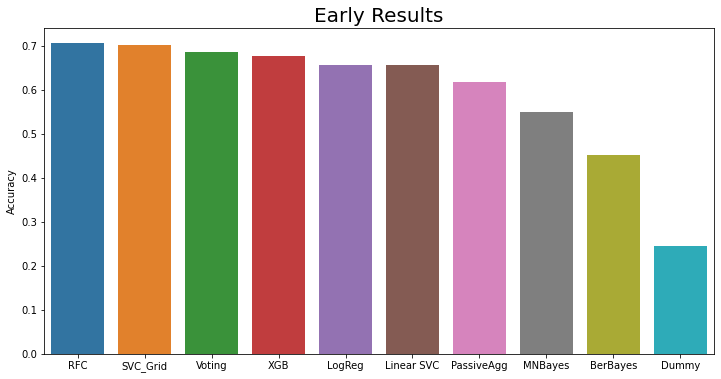

In [81]:
plt.figure(figsize=(12,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Early Results", fontsize=20)
#plt.savefig("../pics/model_performances.png")